## Import Library and Initialize Global Variables

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor

import warnings
warnings.filterwarnings('ignore')

SEED = 41

### What dataset are we using for this exercise?

#### Data Set Information:

The NASA data set comprises different size NACA 0012 airfoils at various wind tunnel speeds and angles of attack. The span of the airfoil and the observer position were the same in all of the experiments.


#### Attribute Information:

This problem has the following inputs:
1. Frequency, in Hertzs.
2. Angle of attack, in degrees.
3. Chord length, in meters.
4. Free-stream velocity, in meters per second.
5. Suction side displacement thickness, in meters.

The only output is:
6. Scaled sound pressure level, in decibels.

You can find the complete description of the dataset [here](https://archive.ics.uci.edu/ml/datasets/Airfoil+Self-Noise#).

## Load Database/Import Data 

In [2]:
df = pd.read_csv("airfoil_self_noise.dat", delimiter='\t',\
                 names= ['Frequency', 'Angle', 'Length', 'Velocity', 'Thickness', 'Pressure'])
df.head()

,Frequency,Angle,Length,Velocity,Thickness,Pressure
0,800,0.0,0.3048,71.3,0.002663,126.201
1,1000,0.0,0.3048,71.3,0.002663,125.201
2,1250,0.0,0.3048,71.3,0.002663,125.951
3,1600,0.0,0.3048,71.3,0.002663,127.591
4,2000,0.0,0.3048,71.3,0.002663,127.461


## Exploratory Data Analysis (EDA)

In [3]:
df.describe()

,Frequency,Angle,Length,Velocity,Thickness,Pressure
count,1503.000000,1503.000000,1503.000000,1503.000000,1503.000000,1503.000000
mean,2886.380572,6.782302,0.136548,50.860745,0.011140,124.835943
std,3152.573137,5.918128,0.093541,15.572784,0.013150,6.898657
min,200.000000,0.000000,0.025400,31.700000,0.000401,103.380000
25%,800.000000,2.000000,0.050800,39.600000,0.002535,120.191000
50%,1600.000000,5.400000,0.101600,39.600000,0.004957,125.721000
75%,4000.000000,9.900000,0.228600,71.300000,0.015576,129.995500
max,20000.000000,22.200000,0.304800,71.300000,0.058411,140.987000


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1503 entries, 0 to 1502
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Frequency  1503 non-null   int64  
 1   Angle      1503 non-null   float64
 2   Length     1503 non-null   float64
 3   Velocity   1503 non-null   float64
 4   Thickness  1503 non-null   float64
 5   Pressure   1503 non-null   float64
dtypes: float64(5), int64(1)
memory usage: 70.6 KB


In [5]:
df.shape

(1503, 6)

In [6]:
df.isna().any().any()
# df.isna().sum()

False

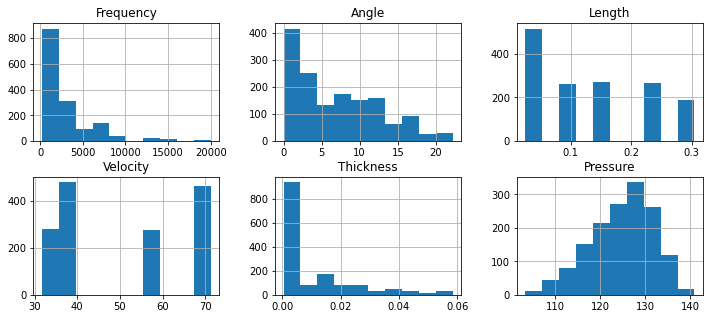

In [7]:
df.hist(figsize=(12,5), layout=(2,3))
plt.show()

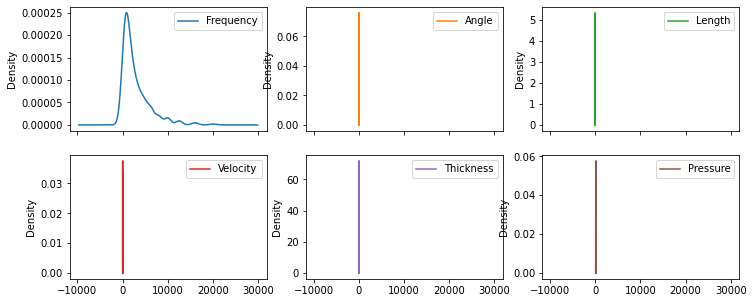

In [8]:
df.plot.kde(figsize=(12,5), layout=(2,3), subplots=True)
plt.show()

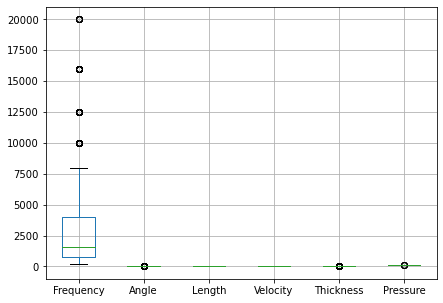

In [9]:
df.boxplot(figsize=(7,5))
plt.show()

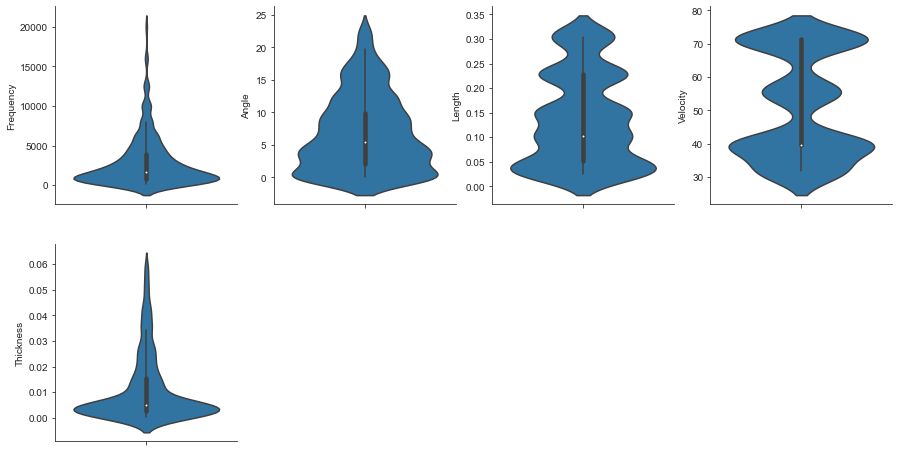

In [10]:
features = list(df.columns)[:-1]

plt.figure(figsize=(15, 8))
sns.set_style('ticks')

for i, feature in enumerate(features):
    plt.subplot(2, 4, i+1)
    sns.violinplot(data=df, y=feature)  
    
sns.despine()

In [11]:
df.nunique()

Frequency      21
Angle          27
Length          6
Velocity        4
Thickness     105
Pressure     1456
dtype: int64

In [12]:
df['Frequency'].value_counts()

2000     105
2500     104
1600     103
3150     103
4000     102
1250     100
1000      99
800       97
5000      95
6300      89
630       88
500       78
400       69
315       56
8000      52
250       42
10000     42
200       35
12500     25
16000     13
20000      6
Name: Frequency, dtype: int64

In [13]:
df['Angle'].value_counts()

0.0     329
4.0      93
15.4     65
7.3      64
12.3     64
9.9      64
17.4     63
3.0      59
9.5      56
2.0      56
5.4      55
4.8      50
3.3      50
8.4      43
12.7     34
7.2      33
6.7      33
12.6     32
8.9      32
1.5      31
2.7      30
5.3      30
22.2     30
15.6     30
11.2     28
19.7     28
4.2      21
Name: Angle, dtype: int64

In [14]:
df['Length'].value_counts()

0.0254    278
0.1524    271
0.2286    266
0.1016    263
0.0508    237
0.3048    188
Name: Length, dtype: int64

In [15]:
df['Velocity'].value_counts()

39.6    480
71.3    465
31.7    281
55.5    277
Name: Velocity, dtype: int64

In [16]:
df['Thickness'].value_counts()

0.005295    23
0.003101    19
0.004978    18
0.003313    18
0.026427    17
            ..
0.000401    10
0.005929     9
0.005781     8
0.005214     8
0.004783     8
Name: Thickness, Length: 105, dtype: int64

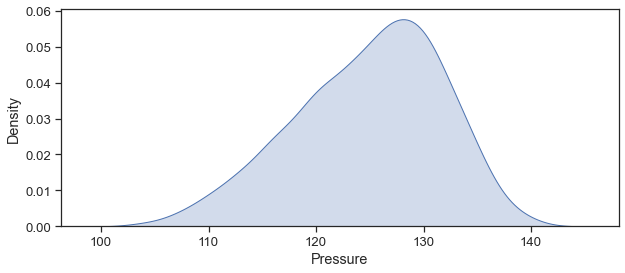

In [17]:
plt.figure(figsize=(10, 4))
sns.set(font_scale= 1.2)
sns.set_style('ticks')
_ = sns.kdeplot(df['Pressure'], shade=True)

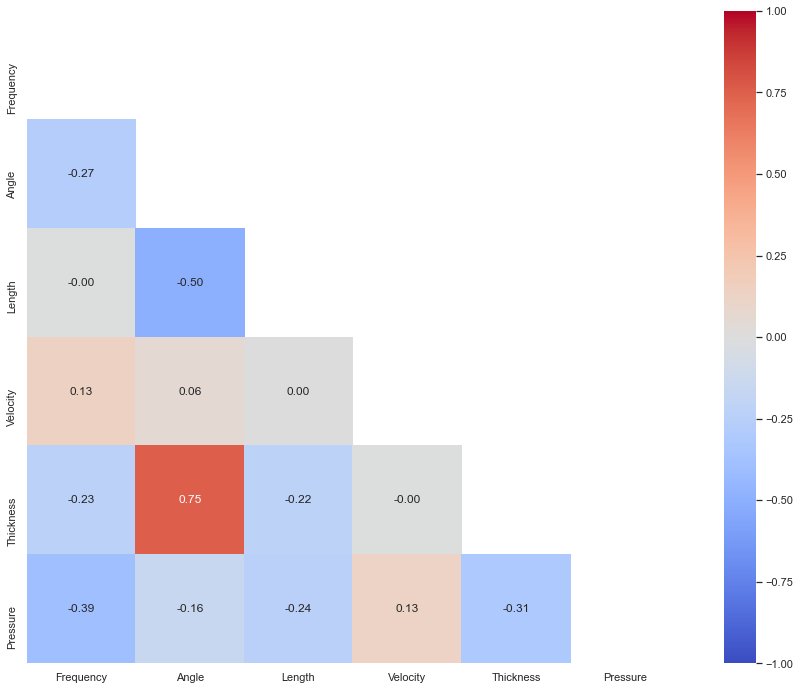

In [18]:
# correlation matrix heatmap visualization
sns.set(style="white")

# Generate a mask for the upper triangle
matrix = np.triu(df.corr())

# Set up the matplotlib figure to control size of heatmap
fig, ax = plt.subplots(figsize=(16,12))

# Plot the heatmap
_ = sns.heatmap(df.corr(), mask=matrix, annot=True, annot_kws={"size": 12}, square=True, 
                cmap='coolwarm' , vmin=-1, vmax=1, fmt='.2f') 

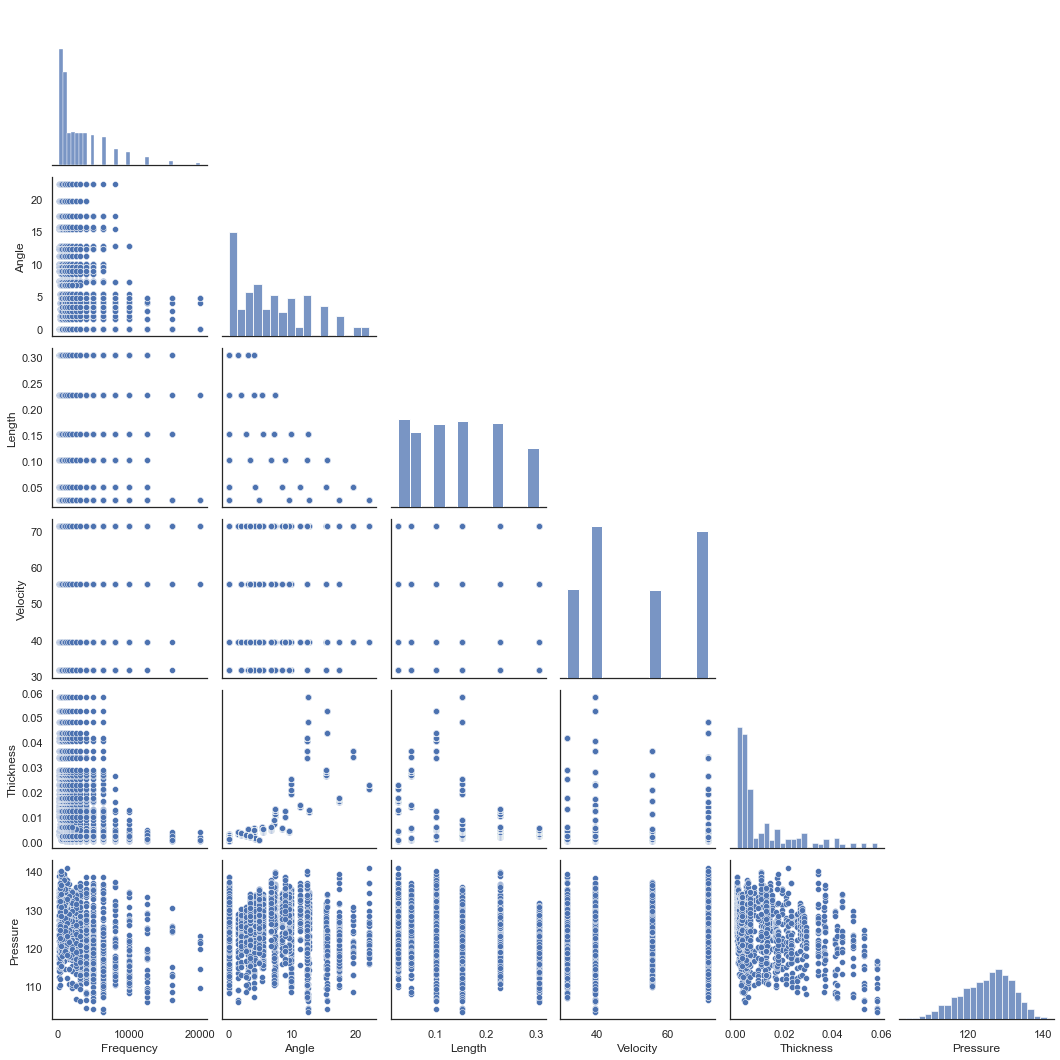

In [19]:
_ = sns.pairplot(df, corner=True)

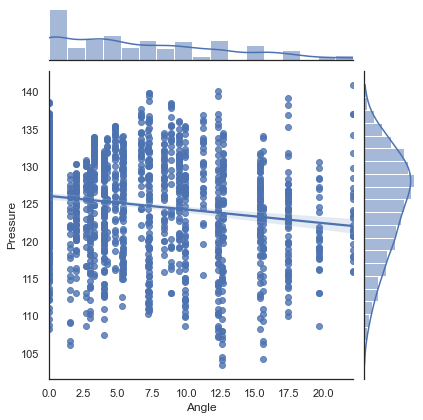

In [20]:
_ = sns.jointplot(x="Angle", y="Pressure", data=df, kind="reg")

## Data Preprocessing/Feature Engineering

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1503 entries, 0 to 1502
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Frequency  1503 non-null   int64  
 1   Angle      1503 non-null   float64
 2   Length     1503 non-null   float64
 3   Velocity   1503 non-null   float64
 4   Thickness  1503 non-null   float64
 5   Pressure   1503 non-null   float64
dtypes: float64(5), int64(1)
memory usage: 70.6 KB


## Model Selection

### Split Data (Features/Target, Train/Validation/Testing)

In [7]:
X = df.drop(['Pressure'], axis=1)
y = df['Pressure']

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)

#### Feature Scaling (Normalization/Standardization)

In [9]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Train a Baseline Model using K-fold Cross Validation
### (start with Logistic Regression for Classification problems, Linear Regression for Regression problems)

In [10]:
%%time
lr_baseline = LinearRegression()
scores = cross_val_score(lr_baseline,
                         X_train_scaled,
                         y_train,
#                          scoring='r2',
                         cv=5,
                         n_jobs=-1)

Wall time: 4.79 s


In [11]:
baseline_mean_score = scores.mean()
print("Baseline Model's score: {:.2f} (avg) {:.2f} (std)".format(scores.mean(), scores.std()))

Baseline Model's score: 0.48 (avg) 0.04 (std)


### Evaluate Multiple Models and Select Best Model

In [12]:
# prepare models
models = []
models.append(('LR', LinearRegression()))
models.append(('SVM', SVR()))
models.append(('RF', RandomForestRegressor(random_state=SEED)))

# evaluate each model in turn
results = []
names = []
scoring = 'r2'

LR : Mean score 0.4782 (Std 0.0354)
SVM: Mean score 0.6651 (Std 0.0190)
RF : Mean score 0.9205 (Std 0.0146)


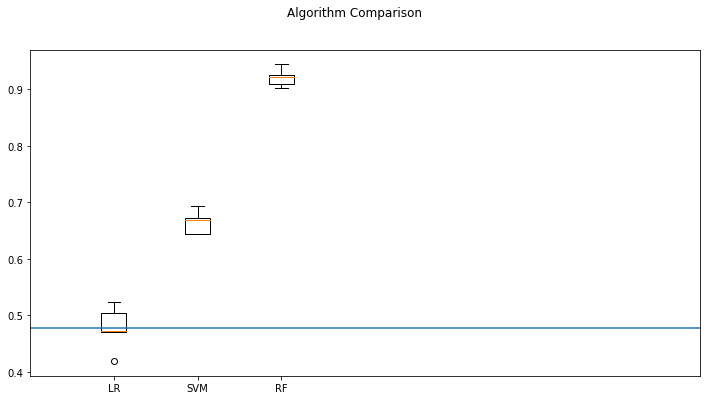

Wall time: 2.77 s


In [13]:
%%time
for name, model in models:
#     kfold = KFold(n_splits=10)
    cv_results = cross_val_score(model, 
                                 X_train_scaled, 
                                 y_train, 
                                 cv=5, 
                                 scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "{:3}: Mean score {:.4f} (Std {:.4f})".format(name, cv_results.mean(), cv_results.std())
    print(msg)

# boxplot algorithm comparison
fig = plt.figure(figsize=(12,6))
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.plot([-2,10], [baseline_mean_score, baseline_mean_score])
plt.xlim(0, 8)
plt.show()

### Hyperparameter Fine-tuning for final selected model

In [14]:
%%time
# Hyperparameter fine-tuning for Random Forest on Regression dataset
parameters = {'n_estimators': [300, 500, 700],
              'max_depth': [5, None],
              'min_samples_split': [2, 3, 5]}
#               'min_samples_leaf': [2, 3, 4],
#               'max_features': ['sqrt', 'log2']}
    
gs_clf = GridSearchCV(RandomForestRegressor(random_state=SEED),
                      parameters, 
                      cv=5,
                      scoring='r2',
#                       scoring='f1_macro',
#                       scoring='roc_auc_ovr',
                      n_jobs=-1)
_ = gs_clf.fit(X_train_scaled, y_train)

final_clf = gs_clf.best_estimator_

print(gs_clf.best_estimator_)
print(gs_clf.best_params_)
print(gs_clf.best_score_)

RandomForestRegressor(n_estimators=500, random_state=41)
{'max_depth': None, 'min_samples_split': 2, 'n_estimators': 500}
0.9220911105303274
Wall time: 53 s


### Evaluate the fine-tuned Model (whether it will generalize well with unseen data - testing dataset)

In [30]:
y_pred = final_clf.predict(X_test_scaled)

r2score = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print('Final Model (Random Forest) Metrics -')
print('\tR2 Score:', r2score)
print('\tMean Absolute Error:', mae)
print('\tMean Square Error:', mse)

Final Model (Random Forest) Metrics -
	R2 Score: 0.9402527863277024
	Mean Absolute Error: 1.334730710963404
	Mean Square Error: 3.4000460659725693


## Post-mortem Analysis

In [31]:
%%time
rf = RandomForestRegressor(oob_score=True, n_jobs=-1, random_state=SEED)
rf.fit(X_train_scaled, y_train)

Wall time: 387 ms


RandomForestRegressor(n_jobs=-1, oob_score=True, random_state=41)

In [32]:
# Creating the feature importances dataframe
feature_importance = np.array(rf.feature_importances_)
feature_names = np.array(X.columns)

feat_imp = pd.DataFrame({'feature_names':feature_names,'feature_importance':feature_importance})
feat_imp_sorted = feat_imp.sort_values('feature_importance', ascending=False)

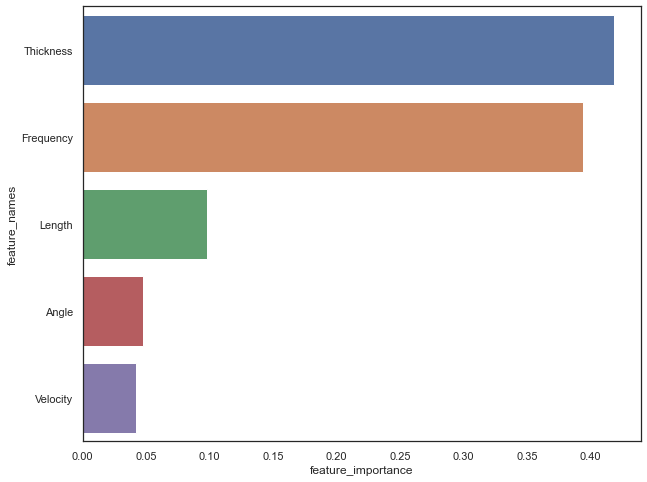

In [33]:
plt.figure(figsize=(10,8))
_ = sns.barplot(x=feat_imp_sorted['feature_importance'], y=feat_imp_sorted['feature_names'])